# Non-Negative  Matrix  Factorization

![image](https://2.bp.blogspot.com/-CkcdVRPCwr8/VGKELrHi-II/AAAAAAAAA-o/LHnZM0XUhe8/s1600/NMF.png)

$min_{V, H} || V - H ||_F$ subject to $W \geq 0, H \geq 0$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.externals import joblib
from sklearn import metrics
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Preprocess data

In [2]:
raw_documents = []
snippets = []
with open( "data.txt", "r") as f:
    for line in f.readlines():
        text = line.strip()
        raw_documents.append( text.lower() )
        
        snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))

Read 4551 raw text documents


In [3]:
# custom stopwords
custom_stop_words = []
with open( "stopwords.txt", "r" ) as f:
    for line in f.readlines():
        custom_stop_words.append( line.strip().lower() )
        
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


In [4]:
# create BoW + tf-idf model
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

terms = vectorizer.get_feature_names()
joblib.dump((A,terms,snippets), "articles-tfidf.pkl") 

Created 4551 X 10285 TF-IDF-normalized document-term matrix


['articles-tfidf.pkl']

In [5]:
# top features from tf-idf model
import operator


sums = np.array(A.sum(axis=0)).ravel()
# map weights to the terms
weights = { term: sums[col] for col, term in enumerate(terms)}
ranking = sorted(weights.items(), key=operator.itemgetter(1), reverse=True)
for i, pair in enumerate( ranking[0:20] ):
    print( "%s (%.2f)" % ( pair[0], pair[1] ) )

trump (190.87)
people (109.90)
eu (109.17)
film (91.35)
uk (89.10)
bank (78.69)
time (76.12)
brexit (67.98)
health (61.59)
government (60.24)
back (60.24)
clinton (59.95)
get (57.37)
world (56.85)
campaign (56.35)
women (55.82)
way (54.95)
before (54.60)
vote (54.33)
work (54.04)


## Apply NMF

In [6]:
(A,terms,snippets) = joblib.load( "articles-tfidf.pkl")

# create the model
k = 10
model = NMF( init="nndsvd", n_components=k ) 

W = model.fit_transform( A )
H = model.components_

In [7]:
W.shape

(4551, 10)

In [8]:
W[0,:].round(2)

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.13,  0.  ,  0.  ,  0.  ,  0.  ,  0.01])

In [9]:
H.shape

(10, 10285)

In [10]:
H[:,terms.index('brexit')].round(2)

array([ 0.99,  0.  ,  0.  ,  0.  ,  0.04,  0.  ,  0.  ,  0.  ,  0.25,  0.  ])

In [11]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: eu, uk, brexit, britain, european, leave, europe, vote, referendum, trade
Topic 02: trump, clinton, donald, republican, campaign, president, hillary, cruz, sanders, presidential
Topic 03: film, films, movie, star, director, hollywood, actor, story, drama, cinema
Topic 04: league, season, leicester, goal, premier, united, city, liverpool, game, ball
Topic 05: bank, banks, banking, financial, rbs, customers, shares, deutsche, barclays, lloyds
Topic 06: health, nhs, care, patients, mental, doctors, hospital, people, services, junior
Topic 07: album, music, band, song, pop, songs, rock, love, sound, bowie
Topic 08: facebook, internet, online, twitter, users, google, people, media, company, amazon
Topic 09: labour, party, corbyn, cameron, referendum, vote, voters, campaign, johnson, minister
Topic 10: women, abortion, woman, men, cancer, female, ireland, girls, rights, northern


In [12]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

topic_snippets = get_top_snippets( snippets, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. Brexit X-men: how the prime minister’s key negotiators are coping When Boris Johnson was working for
02. Archbishop accuses Farage of racism and 'accentuating fear for political gain' – EU referendum live 
03. Brexit could shift Europe's political centre of gravity, says Fitch A vote for Brexit in next month’
04. EU leaders line up to insist UK will pay a high price for Brexit stance Britain and the EU appear mo
05. Would Brexit make UK businesses less competitive? In this week’s EU referendum Q&A our panel discuss
06. David Cameron: being in the EU gives Britain key counter-terrorism information David Cameron has sai
07. Slovakian foreign minister: I will support any measure to stop Brexit The new Slovakian EU presidenc
08. Brexit weekly briefing: we're going to be kept in the dark Welcome to the weekly Brexit briefing, a 
09. What would Brexit mean for housing, regeneration and central government? Housing and regeneration: T
10. Cameron names referendum date as Gove declares for 

In [13]:
joblib.dump((W,H,terms,snippets), "articles-model-nmf-k%02d.pkl" % k) 

['articles-model-nmf-k10.pkl']

## Topic coherence

In [14]:
kmin, kmax = 4, 15

topic_models = []
for k in tqdm(range(kmin,kmax+1)):
    model = NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    topic_models.append( (k,W,H) )

100%|██████████| 12/12 [00:19<00:00,  1.65s/it]


In [15]:
import re
import gensim


class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens
            

docgen = TokenGenerator( raw_documents, custom_stop_words )
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)
print( "Model has %d terms" % len(w2v_model.wv.vocab) )
w2v_model.save("w2v-model.bin")

Model has 12192 terms


Calculate topic coherence TC-W2C as a mean pairwise similarity of words from topic. 

In [16]:
from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.3563
K=05: Coherence=0.3958
K=06: Coherence=0.4359
K=07: Coherence=0.4563
K=08: Coherence=0.4633
K=09: Coherence=0.4573
K=10: Coherence=0.4559
K=11: Coherence=0.4553
K=12: Coherence=0.4598
K=13: Coherence=0.4588
K=14: Coherence=0.4530
K=15: Coherence=0.4518


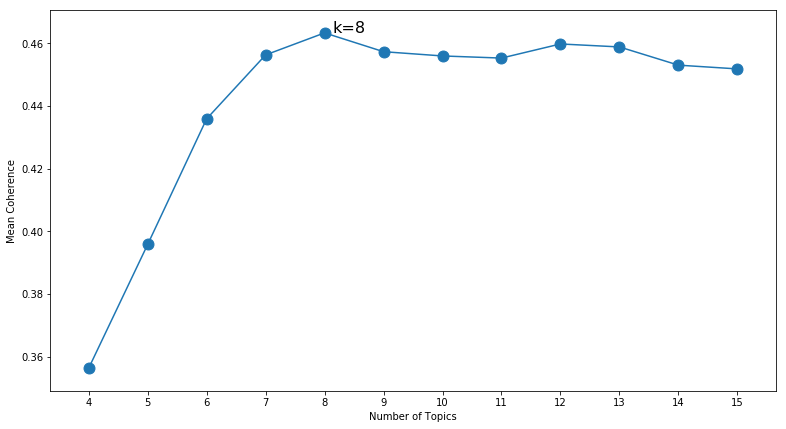

In [17]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [18]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: eu, brexit, uk, britain, referendum, leave, vote, european, cameron, labour
Topic 02: trump, clinton, republican, donald, campaign, president, hillary, cruz, sanders, election
Topic 03: film, films, movie, star, hollywood, director, actor, story, drama, women
Topic 04: league, season, leicester, goal, premier, united, city, liverpool, game, ball
Topic 05: bank, banks, banking, financial, rbs, customers, shares, deutsche, barclays, lloyds
Topic 06: health, nhs, care, patients, mental, doctors, hospital, people, services, junior
Topic 07: album, music, band, song, pop, songs, rock, love, sound, bowie
Topic 08: internet, facebook, online, people, twitter, media, users, google, company, amazon
